# Visual representation of different image sources  

In [4]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

## Set the seed for reproducibility

In [5]:
SEED = 44
np.random.seed(SEED)
random.seed(SEED)

## Load the data

In [6]:
import os

data_path = "data/features/genimage/standard"
suffix = "train/features_RGB.csv"
biggan_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0419_biggan", suffix), index_col=0)
vqdm_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0419_vqdm", suffix), index_col=0)
sdv5_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0424_sdv5", suffix), index_col=0)
wukong_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0424_wukong", suffix), index_col=0)
adm_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0508_adm", suffix), index_col=0)
glide_train = pd.read_csv(os.path.join(data_path, "imagenet_glide", suffix), index_col=0)
midjourney_train = pd.read_csv(os.path.join(data_path, "imagenet_midjourney", suffix), index_col=0)
mid_sd = pd.concat([sdv5_train, midjourney_train])
combined_train = pd.concat([biggan_train, vqdm_train, sdv5_train, wukong_train, adm_train, glide_train, midjourney_train])

datasets_train = {
    "biggan": biggan_train,
    "vqdm": vqdm_train,
    "sdv5": sdv5_train,
    "wukong": wukong_train,
    "adm": adm_train,
    "glide": glide_train,
    "midjourney": midjourney_train,
    # "mid_sd": mid_sd,
    # "combined": combined_train,
}

In [7]:
img_train = pd.concat([dataset[dataset['Category'] == 'nature'] for dataset in datasets_train.values()])
img_train["Category"] = "real"
img_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14000 entries, 0 to 1999
Columns: 2553 entries, Image to B_lbp-2D_ngtdm_Strength
dtypes: float64(2495), int64(4), object(54)
memory usage: 272.8+ MB


In [8]:
# drop non-ai images from generators datasets
for dataset_name, dataset in datasets_train.items():
    # leave only ai images
    dataset = dataset[dataset['Category'] == 'ai']

# add real images to datasets
datasets_train["real"] = img_train

## Data preparation

In [9]:
def drop_columns(df, drop_only_diagnostic=False):
    to_drop = list()
    for column in df.columns:
        if df[column].min() == df[column].max() and not drop_only_diagnostic:
            to_drop.append(column)
        elif 'diagnostics' in column:
            to_drop.append(column)
        elif 'Mask' in column:
            to_drop.append(column)
    df.drop(to_drop, axis=1, inplace=True)
            
def preprocess_dataset(df, **kwargs):
    # print indexes and image names of rows with NaN values
    nans = df[df.isnull().any(axis=1)]['Image'].apply(lambda x : x.split('/')[-1])
    if not nans.empty:
        print(f"Rows with NaN values:")
        print(nans)
    df.dropna(inplace=True)  
    drop_columns(df, **kwargs)
    
def unify_columns(base_columns, df):
    # drop columns that are not in base_columns
    for column in df.columns:
        if column not in base_columns:
            df.drop(column, axis=1, inplace=True)

### Drop unimportant columns

In [10]:
# We drop only columns from train set
for key, df in datasets_train.items():
    preprocess_dataset(df, drop_only_diagnostic=True)

Rows with NaN values:
2726    006_biggan_00182.png
2842    107_biggan_00008.png
Name: Image, dtype: object


### Split into train and test set

In [11]:
from sklearn.model_selection import train_test_split

X_train = {}
X_val = {}

y_train = {}
y_val = {}

Image_train = {}
Image_val = {}

for key, df in datasets_train.items():
    X = df.drop('Category', axis=1)
    # make y to be equal to dataset name
    y = df['Category']
    y = y.apply(lambda x: key)
    
    # get train, val and test sets
    X_train[key], X_val[key], y_train[key], y_val[key] = train_test_split(X, y, test_size=0.2, random_state=SEED)
    
    Image_train[key] = X_train[key]['Image']
    Image_val[key] = X_val[key]['Image']
    
    X_train[key] = X_train[key].drop('Image', axis=1)
    X_val[key] = X_val[key].drop('Image', axis=1)
    
# create dataset combining all train sets
X_train_all = pd.concat([X_train[key] for key in datasets_train.keys()])
y_train_all = pd.concat([y_train[key] for key in datasets_train.keys()])

# create dataset combining all val sets
X_val_all = pd.concat([X_val[key] for key in datasets_train.keys()])
y_val_all = pd.concat([y_val[key] for key in datasets_train.keys()])

X_train['combined'] = X_train_all
y_train['combined'] = y_train_all

X_val['combined'] = X_val_all
y_val['combined'] = y_val_all

### Scale the data

In [12]:
from sklearn.preprocessing import MinMaxScaler

scalers = {}
X_train_scaled = {}
for key in X_train.keys():
    scalers[key] = MinMaxScaler()
    X_train_scaled[key] = scalers[key].fit_transform(X_train[key])
    X_train_scaled[key] = pd.DataFrame(X_train_scaled[key], columns=X_train[key].columns)

## LDA

In [13]:
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_r2 = lda.fit(X_train_scaled['combined'], y_train['combined']).transform(X_train_scaled['combined'])

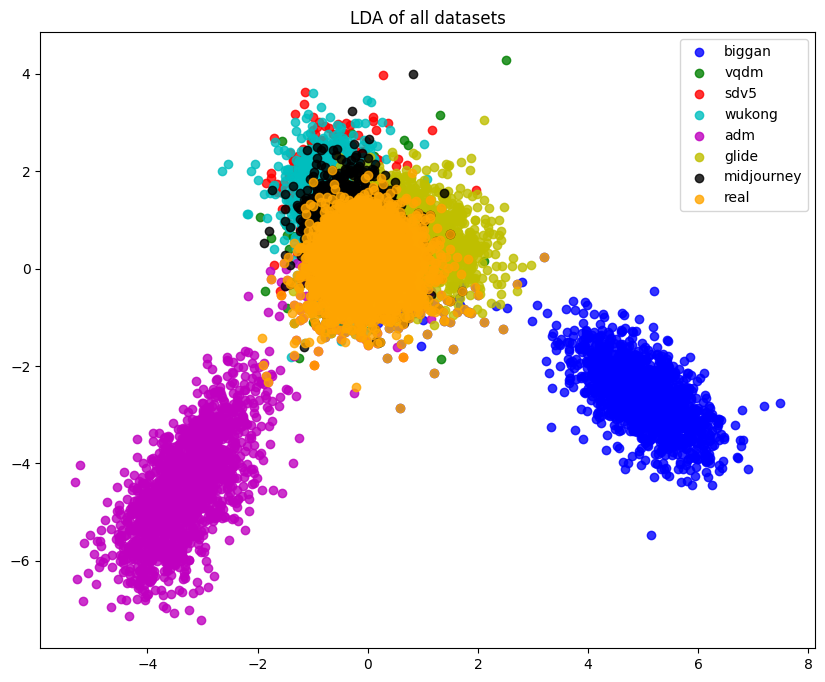

In [14]:
plt.figure(figsize=(10, 8))

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']

for color, dataset_name in zip(colors, datasets_train.keys()):
    plt.scatter(X_r2[y_train['combined'] == dataset_name, 0], X_r2[y_train['combined'] == dataset_name, 1], alpha=.8, color=color, label=dataset_name)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of all datasets')
plt.show()